In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import math
import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [11]:
device = torch.device('cpu')
output_folder = 'NL'
# 读取数据集为训练
def read_data(path):
    data = pd.read_csv(path)
    x = data.values[:, :-1]  # 特征
    y = data.values[:, -1]   # 目标
    return x, y

# 准备数据
x_train, y_train = read_data(f'data_exp/{output_folder}/train_set.csv')
x_test, y_test = read_data(f'data_exp/{output_folder}/test_set.csv')
x_val, y_val = read_data(f'data_exp/{output_folder}/val_set.csv')

# 转换为 PyTorch 张量
def d2tensor(x):
    return torch.FloatTensor(x).to(device)

train_x = d2tensor(x_train)
train_y = d2tensor(y_train).reshape(-1, 1)
val_x = d2tensor(x_val)
val_y = d2tensor(y_val).reshape(-1, 1)
test_x = d2tensor(x_test)
test_y = d2tensor(y_test).reshape(-1, 1)
train_x=train_x.unsqueeze(2)
test_x=test_x.unsqueeze(2)
val_x=val_x.unsqueeze(2)


# 输出确认
print("训练集形状:", train_x.shape, train_y.shape)
print("验证集形状:", val_x.shape, val_y.shape)
print("测试集形状:", test_x.shape, test_y.shape)

训练集形状: torch.Size([28168, 13, 1]) torch.Size([28168, 1])
验证集形状: torch.Size([3522, 13, 1]) torch.Size([3522, 1])
测试集形状: torch.Size([3521, 13, 1]) torch.Size([3521, 1])


In [12]:
import torch.nn as nn
# 定义LSTM的结构

class LSTM_(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM_, self).__init__()
        # 定义常量
        self.input_size = input_size
        self.hidden_size=hidden_size      
        self.output_size=output_size
        LAYERS = 1   
        self.lstm = nn.LSTM(
            input_size = self.input_size, 
            hidden_size = self.hidden_size, 
            num_layers = LAYERS,
            bidirectional =True, 
            batch_first = True    # 如果为True，输入输出数据格式是(batch, seq_len, feature) 为False，输入输出数据格式是(seq_len, batch, feature)，
        )
        # self.sig2 = nn.ReLU()  # ReLU Softmax Sigmoid GELU
        self.hidden = nn.Linear(self.hidden_size*2, 10)  # 最后一个时序的输出接一个全连接层
        self.output = nn.Linear(10, self.output_size) #
        self.h_s = None
        self.h_c = None

        
    def forward(self, x): 
        # x是输入数据集
        out, (h_n, c_n) = self.lstm(x)
        # 此时可以从out中获得最终输出的状态h h_n
        # x = out[:, -1, :]
        # x = h_n[-1, :, :]
        x = torch.cat([h_n[-2],h_n[-1]],dim=1)
        #   x = self.out1(x) 
        # x = self.sig2(x)
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x

Training: 100%|██████████| 5000/5000 [28:00<00:00,  2.98it/s]

Standard deviation of predictions: nan
train_loss:0.001344 , test_loss:nan


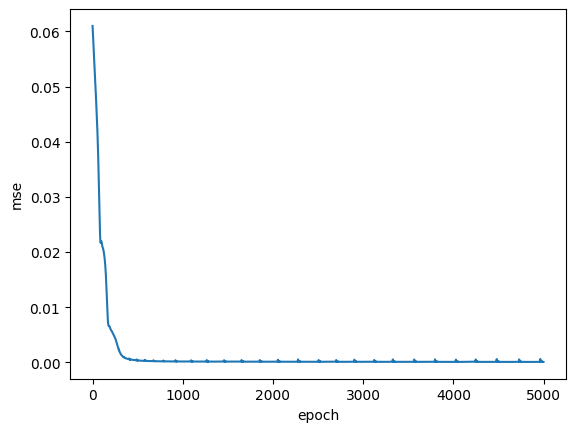

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm  # 引入 tqdm 库

max_epoch = 5000
l_arr = []

def meta_train():
    model = LSTM_(input_size=train_x.shape[-1], hidden_size=13, output_size=2).to(device)
    net = DNN(model=model).to(device)
    net.train()
    # 3 定义优化器和损失函数
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001) 

    # 4 训练网络
    with tqdm(total=max_epoch, desc="Training") as pbar:  # 使用 with 确保进度条正确关闭
        for i in range(max_epoch):
            predict = net(train_x)
            l = loss(train_y, predict)
            optimizer.zero_grad()    
            l.backward()
            optimizer.step()
            l_arr.append(l.item())
            pbar.update(1)  # 手动更新进度条

    # 5 测试网络效果
    predict = net(test_x.to(device=device))
    print(f"Standard deviation of predictions: {predict.std().item():.6f}")
    if predict.std() < 1e-3:
        print("Standard deviation < 1e-3, restarting training...")
        l_arr.clear()
        return meta_train()  # 递归调用
    test_loss = loss(test_y, predict)
    print('train_loss:%.6f , test_loss:%.6f' % (torch.FloatTensor(l_arr).mean(), test_loss.item()))
    return model, predict, net

model, predict, net = meta_train()

# 图1
x = np.arange(len(l_arr))
y = np.array(l_arr)
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

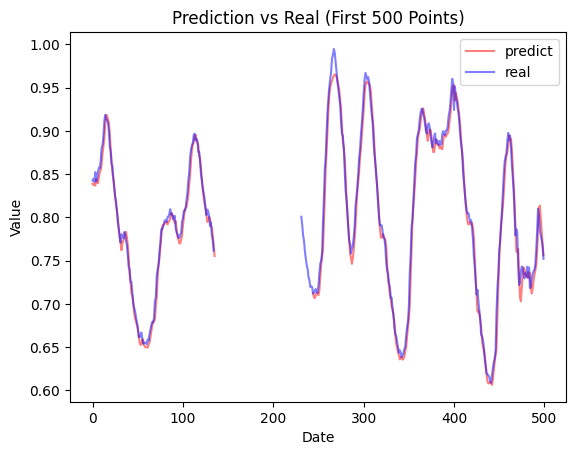

In [18]:
x = np.arange(x_test.shape[0])
y1 = np.array(predict.cpu().detach().numpy())
y2 = np.array(y_test)

# 如果 y1 和 y2 是二维的，将其展平为1维
if len(y1.shape) > 1:
    y1 = y1.flatten()
if len(y2.shape) > 1:
    y2 = y2.flatten()

# 取前500个点
x_sliced = x[:500]
y1_sliced = y1[:500]
y2_sliced = y2[:500]

# 创建折线图
line1, = plt.plot(x_sliced, y1_sliced, color='red', alpha=0.5, label="predict")
line2, = plt.plot(x_sliced, y2_sliced, color='blue', alpha=0.5, label="real")

# 添加图例
plt.legend([line1, line2], ["predict", "real"], loc=1)

# 添加标题和坐标轴标签
plt.title("Prediction vs Real (First 500 Points)")
plt.xlabel("Date")
plt.ylabel("Value")

# 保存图像
plt.savefig('prediction_vs_real.png')

Error preparing data: Data contains NaN or Inf values


ValueError: Data contains NaN or Inf values